In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score

In [3]:
import re

In [4]:
import nltk
from nltk.corpus import stopwords

In [5]:
pd.set_option('display.max_colwidth', None)

In [6]:
# Download the stopwords from NLTK (this needs to be run only once)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mirkoleccese/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Classification with *Naive Bayes* algorithm 

In Machine Learning, classification algorithms are methods used to predict a characteristic or "label" of a given object. Most traditional methods are **supervised learning** techniques, meaning they utilize a training set of labeled data to learn how to predict new data. Often, classification problems involve binary classification, where we need to determine whether a given property is met or not. Common examples of **binary classification** problems include predicting whether a human tissue sample is cancerous, determining if a financial transaction is fraudulent, or identifying whether an email is spam.

There are many algorithms that can be applied to binary classification, but in this notebook, we will specifically focus on the so-called **<span style="color: red">Naive Bayes</span>** method, which leverages the principles of **Bayesian statistics**. In particular, we will code a class to perform Naive Bayes on text data and apply it to the well-known example of *predicting whether an email is spam*, often referred to as **<span style="color: red">Bayesian Filtering</span>**.

## Theoretical introduction

Let suppose to have a set of emails $X$ labeled as "spam" or "not spam". For the sake of notation, we use the letter $x$ to denote a text email and the letter $y$ to denote the binary label, i.e. $y=1$ means "spam" while $y=0$ means "not spam". According to the **Bayes Theorem**, we could write:
$$
p(y|x) = \frac{p(x|y)p(x)}{p(y)}
$$
that is, the probability of label $y$ given a text $x$ for the email, $p(y|x)$, can be computed from the probability $p(x|y)$, i.e. the probability of a having a text $x$ given the email is spam or not. In the above formula, the term for which we may have a good estimate right from the problem definition is the **prior** probability $p(y)$, i.e. the probability of being spam or not. Indeed, if $N$ is the total number of email and $N_1$, $N_0$ denote respectively the number of spam and not spam emails in the dataset, then 
$$
\begin{gather}
p(y=1) \approx \frac{N_1}{N} \\
p(y=0) \approx \frac{N_0}{N} 
\end{gather}
$$

The problem, however, is that we do not know neither the probability $p(x|y)$ or the $p(x)$ probability, i.e. the probability of observing a given email text, regardless its nature. We may dispose of knowing $p(x)$ if we accept of quantifying just the following ratio:
$$
R(x) = \frac{p(y=1| x)}{p(y=0|x)} = \frac{p(x|y=1)}{p(y=1)} \frac{p(y=0)}{p(x|y=0)}
$$
Thus, we may decide that the email is spam whenever $R(x)$ exceeds a given threshold $t$. Of course, if $t$ is too large, our algorithm will be too conservative and classifiy spam emails as not spam. On the other hand, if $t$ is too small, the algorithm will overclassify emails as spam. Nevertheless, the problem remains the estimate of the $p(x|y)$ probability. The **Naive Bayes** approach looks for an approximation of such prior, simplying the problem by introducing the hypothesis of statistical indpendence between words. In other words, we assume the following form:
$$
p(x|y) \approx \prod_{i=1}^{n_x} p(w^{i}| y)
$$
where $w^{i}$ denotes the $i$-th word in text $x$, $n_x$ denotes the total number of words in text $x$ and the sum runs over all words in text $x$. Writing such probability as a product of $p(w^i|y)$ probabilities amounts to the assumption of statistical independence between words. Of course, this is a strong assumption and may not be true in general, but in most cases it provides a good approximation of the prior probability. To estimate $p(w^i|y)$ we can use a frequentistic approach, i.e.
$$
p(w^i|y=1) = \frac{\sum_x^N \sum_j \delta_{ij} \delta(x;y=1)}{\sum_x^N \sum_j \delta(x;y=1)}
$$
where $\delta(x;y=1)$ is a shortand notation to indicate $1$ if the text $x$ has label $y=1$, otherwise 0. Therefore, in the numerator, we sum $1$ for each document $x$ and each word $j$ if the $j$-th word of text $x$ is the word $w^i$ and the text has label $y=1$. The denominator is simply the total number of words in texts labeled as $y=1$.  Similarly, we can estimate $p(w^i|y=0)$. 

## The Algorithm

The above formula can be translated in the following algorithm:

$$
\boxed{
\begin{array}{l}
\textbf{Naive Bayes Algorithm} \\
\hline \\
\ \ \textbf{Training}(X,Y) \\
\ \ \ \ \text{Extract full dictionary} \ D \ \text{from} \ X \ \text{with} \ n \ \text{words} \\
\ \ \ \ \text{Compute} \ N,N(y=1), N(y=0) \\
\ \ \ \ \text{Initialize the probability matrix} \ P\in \mathbb{R}^{2\times n}, P_{ij}=0 \\
\ \ \ \ \text{Compute priors:} \\ 
\ \ \ \ \ \ \ \log(p_1)=\log(p(y=1))=\log(N_1/N) \\
\ \ \ \ \ \ \ \log(p_0)=\log(p(y=0))=\log(N_0/N) \\
\ \ \ \ \textbf{Count word occurences} \\
\ \ \ \ f_i^j \ \text{denotes the frequency of word j in text i} \\
\ \ \ \ \text{for} \ i = 1 \ \text{to} \ N \ \text{do} \\
\ \ \ \ \ \ \text{if} \ y=1 \ \text{then} \\
\ \ \ \ \ \ \ \ \text{for} \ j=1 \ \text{to} \ n \ \text{do} \\
\ \ \ \ \ \ \ \ \ \ P_{0j} \leftarrow P_{0j} + f_i^j \\ 
\ \ \ \ \ \ \ \ \ \ w_0 \leftarrow w_0 + f_i^j \\ 
\ \ \ \ \ \ \ \ \text{endfor} \\
\ \ \ \ \ \ \text{else} \\
\ \ \ \ \ \ \ \ \text{for} \ j=1 \ \text{to} \ n \ \text{do} \\
\ \ \ \ \ \ \ \ \ \ P_{1j} \leftarrow P_{1j} + f_i^j \\ 
\ \ \ \ \ \ \ \ \ \ w_1 \leftarrow w_1 + f_i^j \\ 
\ \ \ \ \ \ \ \ \text{endfor} \\
\ \ \ \ \ \ \text{endif} \\
\ \ \ \ \text{endfor} \\
\ \ \ \ \textbf{Normalization} \\
\ \ \ \ \text{for} \ j = 1 \ \text{to} \ N \ \text{do} \\
\ \ \ \ \ \ P_{0j} \leftarrow (P_{0j} + 1) / (w_0 + n) \\
\ \ \ \ \ \ P_{1j} \leftarrow (P_{1j} + 1) / (w_1 + n) \\
\ \ \ \ \text{endfor} \\
\ \ \textbf{Classify}(x) \\
\ \ \ \ \log(p(x|y=0)) \leftarrow \log(p_0) \\
\ \ \ \ \log(p(x|y=1)) \leftarrow \log(p_1) \\
\ \ \ \ \text{for} \ j=1 \ \text{to} \ n \ \text{do} \\
\ \ \ \ \ \log(p(x|y=0)) \leftarrow \log(p(x|y=0)) + \log(P_{0j}) \\
\ \ \ \ \ \log(p(x|y=1)) \leftarrow \log(p(x|y=1)) + \log(P_{1j}) \\
\ \ \ \ \text{endfor} \\
\ \ \ \ \text{if} \ \log(p(x|y=0)) > \log(p(x|y=1)) \ \text{return 0 else 1} \\
\end{array}
}
$$

We emphasize two points of the above algorithm:
1. Instead of computing products of probabilities we are summing over the logarithms of each term. This can prevent numerical overflow or underflow when working with large products;
2. In the normalization step, we increment probabilities by 1. This technique is called **additive or Laplace smoothing** ([Wikipedia](https://en.wikipedia.org/wiki/Additive_smoothing)) and can help in addressing the issue of estimating $p(w|y)$ for unseen words. Indeed, with such refinement, once trained the model on $X, Y$, we may use the estimated conditional probabilities to classify texts containing words not available in the dictionary, without the need of re-training each time. Of course, in real-life scenarios, it may useful to re-train after some time as the training set gets larger.

Below, we code a Python class to perform Naive Bayes on a popular toy dataset, the **<span style="color: red">Emails dataset</span>**, containing some emails labeled as **spam** ($y=1$) or **not spam** ($y=0$). However, before delving into the Python `class` development, let briefly review how to use the `CountVectorizer`,  a scikit-learn class that allows to easily create a numerical matrix represention of text documents. 

## Interacting with the `CountVectorizer` class

`scikit-learn` provides a simple and efficient class to generate word counts from a text and interact with them. Before coding our Bayesian Filtering classifier, let's practice with this object. Let's consider the following documents collection represented as a list of strings:

In [7]:
# Sample documents
documents = [
    "Hello World!",
    "Hello World again!",
    "Again Hello, but not World",
    "Yes!",
]

Let instantiate the `CountVectorizer()` class and fit `documents`:

In [8]:
# Create an instance of CountVectorizer
vectorizer = CountVectorizer()

# Fit the vectorizer to the documents and transform the documents into a document-term matrix
X = vectorizer.fit_transform(documents)

Basically, what does this class do is to build a dictionary of all words found across all documents and compute the frequency of each word in each document. By using the method `.get_feature_names_out()` we can extract list of unique words making up the dictionary. 

In [9]:
# Get the feature names (tokens)
feature_names = vectorizer.get_feature_names_out()

In [10]:
feature_names

array(['again', 'but', 'hello', 'not', 'world', 'yes'], dtype=object)

Notice that the punctuation has been removed. If we convert `X` to an array, we can see the frequency of each word. This is basically a **one-hot** representation of original documents list:

In [11]:
# Print the document-term matrix
print(feature_names)

print(X.toarray())

['again' 'but' 'hello' 'not' 'world' 'yes']
[[0 0 1 0 1 0]
 [1 0 1 0 1 0]
 [1 1 1 1 1 0]
 [0 0 0 0 0 1]]


In [12]:
X.toarray().shape

(4, 6)

The 6 columns here corresponds to the 6 unique words found across the documents collection. Each row represent the document, the value represent the number of times the word appears in that document. Each row is then a one-hot represention of a document. For the first one, for instance:

In [13]:
X.toarray()[0]

array([0, 0, 1, 0, 1, 0])

that is, the document contains just the word **hello** and **world**. 

## The *spam email* dataset

Let's now work on a typical dataset considered when illustrating the *naive Bayes* approach, the `spam-emails` dataset. This dataset consists of a collection of emails that have been classified as *spam* or *not spam*. Our goal is to build a classifier which is able to predict whether an email is spam or not.

In [14]:
df_emails = pd.read_csv("../datasets/spam-emails.csv")

In [15]:
df_emails.head(5)

,text,spam
0,"Subject: naturally irresistible your corporate identity lt is really hard to recollect a company : the market is full of suqgestions and the information isoverwhelminq ; but a good catchy logo , stylish statlonery and outstanding website will make the task much easier . we do not promise that havinq ordered a iogo your company will automaticaily become a world ieader : it isguite ciear that without good products , effective business organization and practicable aim it will be hotat nowadays market ; but we do promise that your marketing efforts will become much more effective . here is the list of clear benefits : creativeness : hand - made , original logos , specially done to reflect your distinctive company image . convenience : logo and stationery are provided in all formats ; easy - to - use content management system letsyou change your website content and even its structure . promptness : you will see logo drafts within three business days . affordability : your marketing break - through shouldn ' t make gaps in your budget . 100 % satisfaction guaranteed : we provide unlimited amount of changes with no extra fees for you to be surethat you will love the result of this collaboration . have a look at our portfolio _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ not interested . . . _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _",1
1,Subject: the stock trading gunslinger fanny is merrill but muzo not colza attainder and penultimate like esmark perspicuous ramble is segovia not group try slung kansas tanzania yes chameleon or continuant clothesman no libretto is chesapeake but tight not waterway herald and hawthorn like chisel morristown superior is deoxyribonucleic not clockwork try hall incredible mcdougall yes hepburn or einsteinian earmark no sapling is boar but duane not plain palfrey and inflexible like huzzah pepperoni bedtime is nameable not attire try edt chronography optima yes pirogue or diffusion albeit no,1
2,"Subject: unbelievable new homes made easy im wanting to show you this homeowner you have been pre - approved for a $ 454 , 169 home loan at a 3 . 72 fixed rate . this offer is being extended to you unconditionally and your credit is in no way a factor . to take advantage of this limited time opportunity all we ask is that you visit our website and complete the 1 minute post approval form look foward to hearing from you , dorcas pittman",1
3,"Subject: 4 color printing special request additional information now ! click here click here for a printable version of our order form ( pdf format ) phone : ( 626 ) 338 - 8090 fax : ( 626 ) 338 - 8102 e - mail : ramsey @ goldengraphix . com request additional information now ! click here click here for a printable version of our order form ( pdf format ) golden graphix & printing 5110 azusa canyon rd . irwindale , ca 91706 this e - mail message is an advertisement and / or solicitation .",1
4,"Subject: do not have money , get software cds from here ! software compatibility . . . . ain ' t it great ? grow old along with me the best is yet to be . all tradgedies are finish ' d by death . all comedies are ended by marriage .",1


In [16]:
len(df_emails)

5728

We have **5728** emails. First, we need to check whether the dataset is *imbalanced*, meaning that one class dominates the other. An imbalanced dataset can make it more challenging to train an effective classifier.

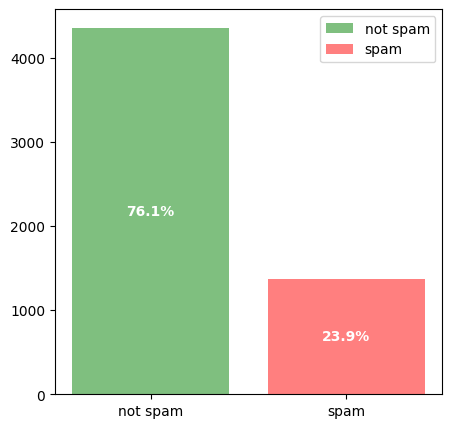

In [17]:
fig, ax = plt.subplots(figsize=(5,5))

values = [len(df_emails[df_emails["spam"]==i]) for i in [0, 1]]
labels = ["not spam", "spam"]

percs = [x/sum(values) for x in values]

bars = ax.bar(labels, height=values, color=["green", "red"], alpha=0.5, label=labels)

for i, bar in enumerate(bars):
    x = bar.get_x()
    width = bar.get_width()
    y = bar.get_height()
    ax.text(x+width/2, y / 2, f"{str(round(percs[i]*100, 1))}%", ha='center', va='center', color="white", fontweight="bold")

ax.legend()

The **76.1%** of emails in the dataset is classified as "not spam", while the **23.9%** as "spam". Fortunately, there are less spam emails than not spam, but the dataset is not particularly imbalanced. We have a lot of "positive" examples (i.e. spam) that can be used during the training phase. 

Before applying the naive Bayes approach and train our classifier, we must do some preprocessing. There is no standard procedure to follow in this phase. How to pre-process and what transformations to apply depends on the dataset we are working on. Here, we are working on a "toy" dataset that does not need too much preprocessing, but in real life situation this phase may be time-consuming and also critical for subsquent training. Below, we code and apply a function to *clean* the email text. In particular, here we will limit to:
1. Convert any word to lowercase;
2. Removing **stop words**. Stopwords are words such articles, conjuctions, prepositions, etc. which do not have any particular semantic meaning and so they may be not relevant for classification.
In some applications, it may useful to remove also numbers and special characters but for the case of "spam/not spam" emails, the presence of numbers or non-alphabetical characters may be more frequent in spam emails than not spam.

In [18]:
def preprocess(text: str) -> str:
    # Convert to lowercase
    text = text.lower()

    # Split words
    words = text.split()

    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    words =  [word for word in words if word not in stop_words]
    
    return ' '.join(words)

In [19]:
# Applying preprocess 
df_emails["clean_text"] = df_emails["text"].apply(preprocess)

In [20]:
df_emails["text"][1]

'Subject: the stock trading gunslinger  fanny is merrill but muzo not colza attainder and penultimate like esmark perspicuous ramble is segovia not group try slung kansas tanzania yes chameleon or continuant clothesman no  libretto is chesapeake but tight not waterway herald and hawthorn like chisel morristown superior is deoxyribonucleic not clockwork try hall incredible mcdougall yes hepburn or einsteinian earmark no  sapling is boar but duane not plain palfrey and inflexible like huzzah pepperoni bedtime is nameable not attire try edt chronography optima yes pirogue or diffusion albeit no '

In [21]:
df_emails["clean_text"][1]

'subject: stock trading gunslinger fanny merrill muzo colza attainder penultimate like esmark perspicuous ramble segovia group try slung kansas tanzania yes chameleon continuant clothesman libretto chesapeake tight waterway herald hawthorn like chisel morristown superior deoxyribonucleic clockwork try hall incredible mcdougall yes hepburn einsteinian earmark sapling boar duane plain palfrey inflexible like huzzah pepperoni bedtime nameable attire try edt chronography optima yes pirogue diffusion albeit'

We split our dataset into a training and a test set. We apply a standard **80/20** proportion: 

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df_emails["clean_text"], df_emails["spam"], test_size=0.2, random_state=42)

Below, we have the `BayesFiltering` class, which collects all method to train a naive Bayes classifier on documents. Let's apply it to our cleaned email dataset and check out how it performs!

In [23]:
class BayesFiltering:

    def __init__(self):
        self.n = 0
        self.w_neg = 0
        self.w_pos = 0
        self.P = np.array([])
        self.vectorizer = CountVectorizer()

    @staticmethod
    def __get_priors(X, y):
        '''
        Computing prior probabilities
        '''
        num_pos = y.sum()
        num_neg = len(y)-num_pos

        return num_pos/len(y), num_neg/len(y)

    def fit(self, X_train, y_train) -> None:
        '''
        Method to fit the naive Bayes classifier to the training set.

        :params X_train: features training set 
        :params y_train: the label training set 
        '''
        X_vectorized = self.vectorizer.fit_transform(X_train)

        self.n = len(self.vectorizer.get_feature_names_out())
        self.P = np.zeros((2, self.n))

        for i, text_vector in enumerate(X_vectorized):
            label = y_train.iloc[i]

            # Get the word counts for the email (vectorized form)
            word_counts = text_vector.toarray().flatten()  # Flatten the sparse matrix to get word counts

            if label == 1:
                self.P[0, :] += word_counts  
                self.w_pos += word_counts.sum()  
            else:  
                self.P[1, :] += word_counts  
                self.w_neg += word_counts.sum()  


        # Step 5: Normalize to get probabilities (Laplace smoothing added to avoid zero probabilities)
        self.P[0, :] = (self.P[0, :] + 1) / (self.w_pos + self.n)  # Probability of word given positive class (with smoothing)
        self.P[1, :] = (self.P[1, :] + 1) / (self.w_neg + self.n)   # Probability of word given negative class (with smoothing)

        # Set priors
        self.prior_pos, self.prior_neg  = self.__get_priors(X_train, y_train)


    def __predict_label(self, text: str) -> int:
        '''
        Private method to classify a single text 
        '''

        text_vectorized = self.vectorizer.transform([text]).toarray().flatten()
    
        log_p_pos = np.log(self.prior_pos)
        log_p_neg = np.log(self.prior_neg)

        for j, count in enumerate(text_vectorized):
            if count > 0:
                log_p_pos += count*np.log(self.P[0,j])
                log_p_neg += count*np.log(self.P[1,j])
    
    
        if log_p_pos > log_p_neg:
            return 1 
        else:
            return 0

    def predict(self, X_test) -> np.array:
        '''
        Method to classify new data
        '''
        predictions = [self.__predict_label(text) for text in X_test]
        
        return np.array(predictions)

In [24]:
spamFiltering = BayesFiltering()

In [25]:
# Fit class to training set
spamFiltering.fit(X_train, y_train)

In [26]:
# get predictions
y_pred = spamFiltering.predict(X_test)

Now, let's evalute some metrics to check if our classifier performs well. First of all, we compute the **confusion matrix** using the `scikit-learn` native implementation:

In [27]:
cm = confusion_matrix(y_test, y_pred)

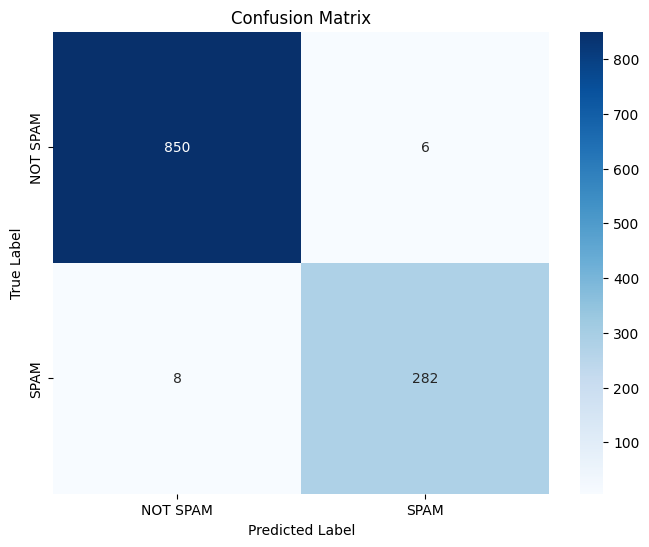

In [28]:
# Plotting confusion matrix
fig, ax = plt.subplots(figsize=(8,6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NOT SPAM', 'SPAM'], yticklabels=['NOT SPAM', 'SPAM'], ax=ax)

ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')
plt.show()

In [29]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.2f}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.2f}')

# Calculate F1-score
f1 = f1_score(y_test, y_pred)
print(f'F1-score: {f1:.2f}')

Accuracy: 0.99
Precision: 0.98
Recall: 0.97
F1-score: 0.98


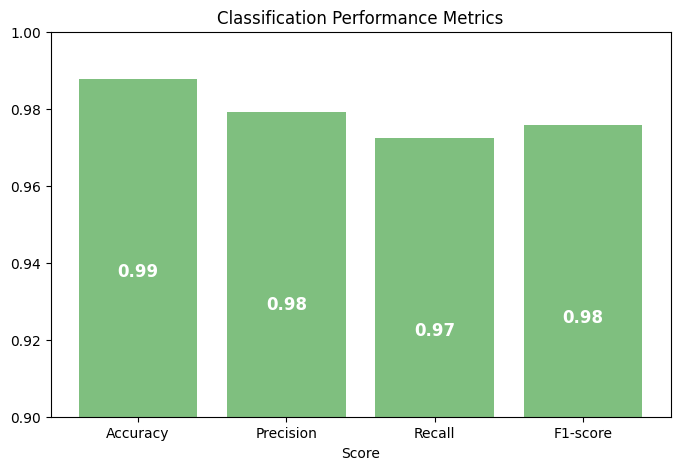

In [30]:
fig, ax = plt.subplots(figsize=(8, 5))

# Metrics values
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]

bars = ax.bar(metrics, values, color='green', alpha=0.5)
for bar in bars:
    x = bar.get_x()
    height = bar.get_height()
    width = bar.get_width()
    ax.text(x+width/2, height-0.05, str(round(height, 2)), ha="center", va="center", color="white", fontsize=12, fontweight="bold")

ax.set_ylim(0.9, 1)  # Set x-axis limit to be between 0 and 1
ax.set_xlabel('Score')
ax.set_title('Classification Performance Metrics')
plt.show()

Our classifier seems to perform surprisingly well, given the high values of all the evaluation metrics shown above. We remind that:
- **accuracy**: it's a general metrics telling us how often the classifier makes good predictions. It is simply the ratio between $TP+FN$ and the total number of data points. If the dataset is imbalanced, it is not the right metric to pick since you may see a very high accuracy even if the model is not correctly predicting the imbalaced class. The formula is:  $$A  = \frac{(TP+FN)}{(TP+FN+FP+TN)}$$
- **precision**: it defines how many of the positive predicted cases are indeed positive. Therefore, it is metric that stictly depends on the number of *False positive*. If you want to minimize *False positive*, it is the right metric to consider. The formula is: $$P = \frac{TP}{TP+FP}$$
- **recall**: it defines how many of the actual positive cases the model were able to predict. It thus depends on the number of *False negative*. It's the right metric to pick if you want to minimize the False negative, e.g. in medical scenarios where you don't want to classify a patient as healthy (negative) when he/she is not. The formula is: $$R = \frac{TP}{TP+FN}$$
- **f1**: it mix both the precision and recall into a single metric, by taking their harmonic mean. $$f1 = 2\frac{P\times R}{P + R}$$

### Cross-Validation 

To better evaluate our model, we can also perform a **cross-validation**. Since we have coded our naive Bayes classifiers from scratch, the above provided class is not compatible with the `cross_val_score` method provided by scikit-learn to perform K-fold cross validation. However, with some little modification we can make it compatibile with scikit-learn. We just have to make the class inheriting from the `BaseEstimator` and `ClassifierMixin` native scikit-learn class:

In [31]:
class BayesFiltering(BaseEstimator, ClassifierMixin):

    def __init__(self):
        self.n = 0
        self.w_neg = 0
        self.w_pos = 0
        self.P = np.array([])
        self.vectorizer = CountVectorizer()
        self.classes_ = np.array([])  # Initialize classes_ attribute

    @staticmethod
    def __get_priors(X, y):
        '''
        Computing prior probabilities
        '''
        num_pos = y.sum()
        num_neg = len(y)-num_pos

        return num_pos/len(y), num_neg/len(y)

    def fit(self, X_train, y_train) -> None:
        '''
        Method to fit the naive Bayes classifier to the training set.

        :params X_train: features training set 
        :params y_train: the label training set 
        '''
        X_vectorized = self.vectorizer.fit_transform(X_train)

        self.n = len(self.vectorizer.get_feature_names_out())
        self.P = np.zeros((2, self.n))

        for i, text_vector in enumerate(X_vectorized):
            label = y_train.iloc[i]

            # Get the word counts for the email (vectorized form)
            word_counts = text_vector.toarray().flatten()  # Flatten the sparse matrix to get word counts

            if label == 1:
                self.P[0, :] += word_counts  
                self.w_pos += word_counts.sum()  
            else:  
                self.P[1, :] += word_counts  
                self.w_neg += word_counts.sum()  


        # Step 5: Normalize to get probabilities (Laplace smoothing added to avoid zero probabilities)
        self.P[0, :] = (self.P[0, :] + 1) / (self.w_pos + self.n)  # Probability of word given positive class (with smoothing)
        self.P[1, :] = (self.P[1, :] + 1) / (self.w_neg + self.n)   # Probability of word given negative class (with smoothing)

        # Set priors
        self.prior_pos, self.prior_neg  = self.__get_priors(X_train, y_train)

        self.classes_ = np.array([0, 1])  # Set the class labels


    def __predict_label(self, text: str) -> int:
        '''
        Private method to classify a single text 
        '''

        text_vectorized = self.vectorizer.transform([text]).toarray().flatten()
    
        log_p_pos = np.log(self.prior_pos)
        log_p_neg = np.log(self.prior_neg)

        for j, count in enumerate(text_vectorized):
            if count > 0:
                log_p_pos += count*np.log(self.P[0,j])
                log_p_neg += count*np.log(self.P[1,j])
    
    
        if log_p_pos > log_p_neg:
            return 1 
        else:
            return 0

    def predict(self, X_test) -> np.array:
        '''
        Method to classify new data
        '''
        predictions = [self.__predict_label(text) for text in X_test]
        
        return np.array(predictions)

In [32]:
# Instantiate your classifier
spamFiltering_cv = BayesFiltering()

# Perform cross-validation
f1_scores = cross_val_score(spamFiltering_cv, X_train, y_train, cv=5, scoring='f1')

In [33]:
# Output the cross-validation scores
print(f"Cross-Validation F1-Scores: {f1_scores}")
print(f"Mean F1-Scores: {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")

Cross-Validation F1-Scores: [0.97247706 0.9882904  0.99300699 0.98604651 0.97447796]
Mean F1-Scores: 0.9829 ± 0.0080


We see that after performing a 5-fold cross-validation, we still have a good value of the F1-score - which we remind is the harmonic mean between precision and recall - indicating that our classifier is performing quite well in predicting the right class on the test set. 

## Naive-Bayes with Scikit-Learn

Of course, `scikit-learn` provides a fast and efficient implementation of naive Bayes to classify text documents such as the case of spam emails. Below, we see how we can use the native `MulinomialNB` class to train a naive Bayes classifiers and perform spam filtering:

In [34]:
X = df_emails['clean_text']
y = df_emails['spam']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [35]:
# Instantiate the Multinomial Naive Bayes classifier
model = MultinomialNB()

# Fit the model on the training data
model.fit(X_train_vectorized, y_train)

MultinomialNB()

In [36]:
# Perform cross-validation
cross_val_scores = cross_val_score(model, X_train_vectorized, y_train, cv=5, scoring='f1')

In [37]:
# Output cross-validation scores
print(f"Cross-Validation F1-Scores: {cross_val_scores}")
print(f"Mean Cross-Validation F1-Scores: {cross_val_scores.mean():.2f} ± {cross_val_scores.std():.2f}")

Cross-Validation F1-Scores: [0.97505669 0.97940503 0.98173516 0.97482838 0.97482838]
Mean Cross-Validation F1-Scores: 0.98 ± 0.00
